**3.6.** The file m sp500ret 3mtcm.txt contains three columns. The second column gives the monthly returns of the S&P 500 index from January 1994 to December 2006. The third column gives the monthly rates of the 3-month U. S. Treasury bill in the secondary market, which is obtained from the Federal Reserve Bank of St. Louis and used as the risk-free asset here. Consider the ten monthly returns in the file m ret 10stocks.txt.

**Pre data cleaning**

In [26]:
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import f, t
import pandas as pd
import numpy as np

In [3]:
# Load and format data
market_df = pd.read_csv('m_sp500ret_3mtcm.csv')
stocks_log_df = pd.read_csv('ret-10-stocks.csv')
stocks_log_df['Date'] = pd.to_datetime(stocks_log_df['Date'])

In [4]:
stocks_names = stocks_log_df.columns[1:]

# Create empty dataset to store normal returns
stocks_ret = pd.DataFrame()

# Compute normal returns for each ticker
for stock in stocks_names:
    stocks_ret[stock] = stocks_log_df[stock].apply(lambda x: np.exp(x) - 1)

In [5]:
# Merge the two datasets
market_stocks_df = pd.concat([market_df[['sp500', '3mTCM']], stocks_ret], axis=1)

num_obs = len(market_stocks_df)
market_stocks_df.index = pd.date_range(start='1994-01-01', periods=num_obs, freq='MS')

# Cast treasury bill rates to decimal instead of percentage
market_stocks_df['3mTCM'] /= 100 

# Market excess return (MER)
market_stocks_df['MER'] = market_stocks_df['sp500'] - market_stocks_df['3mTCM']

market_stocks_df.head(3)

,sp500,3mTCM,AAPL,ADBE,ADP,AMD,DELL,GTW,HP,IBM,MSFT,ORCL,MER
1994-01-01,0.013890,0.0298,0.050129,0.144829,-0.022636,0.064293,-0.012510,0.093338,-0.004323,0.000000,0.023759,0.050335,-0.015910
1994-02-01,-0.013248,0.0325,0.050061,-0.014823,-0.009462,0.020900,0.061397,-0.002164,-0.014283,-0.026493,-0.013451,0.010849,-0.045748
1994-03-01,-0.020336,0.0350,-0.039941,-0.075894,0.000873,0.176181,0.000000,-0.068942,-0.007917,0.014270,0.011702,-0.010732,-0.055336


In [6]:
# Calculate stock excess returns
excess_ret_names = []

for name in stocks_names:
    excess_name = f'{name}_e'
    market_stocks_df[excess_name] = market_stocks_df[name] - market_stocks_df['3mTCM']
    excess_ret_names.append(excess_name)

In [103]:
market_stocks_df.head(3)

,sp500,3mTCM,AAPL,ADBE,ADP,AMD,DELL,GTW,HP,IBM,...,AAPL_e,ADBE_e,ADP_e,AMD_e,DELL_e,GTW_e,HP_e,IBM_e,MSFT_e,ORCL_e
1994-01-01,0.013890,0.0298,0.050129,0.144829,-0.022636,0.064293,-0.012510,0.093338,-0.004323,0.000000,...,0.020329,0.115029,-0.052436,0.034493,-0.042310,0.063538,-0.034123,-0.029800,-0.006041,0.020535
1994-02-01,-0.013248,0.0325,0.050061,-0.014823,-0.009462,0.020900,0.061397,-0.002164,-0.014283,-0.026493,...,0.017561,-0.047323,-0.041962,-0.011600,0.028897,-0.034664,-0.046783,-0.058993,-0.045951,-0.021651
1994-03-01,-0.020336,0.0350,-0.039941,-0.075894,0.000873,0.176181,0.000000,-0.068942,-0.007917,0.014270,...,-0.074941,-0.110894,-0.034127,0.141181,-0.035000,-0.103942,-0.042917,-0.020730,-0.023298,-0.045732


(a). Fit CAPM to the ten stocks. Give point estimates and 95% confidence intervals of $\alpha$, $\beta$, the Sharpe index, and the Treynor index (Hint: Use the delta method for the Sharpe and Treynor indices.)

In [7]:
# Constants
ALPHA_LEVEL = 0.05   # 95% confidence interval

In [8]:
def fit_capm(df, stock_e_names, MER):
    '''
    Fit CAPM. Give point estimates and 95% CIs for alpha, beta.
    Sharpe ratio, and Treynor index.
    '''

    model_list = []
    alphas_list = []

    for stock_e_name in stock_e_names:
        print(f'Analysis for: {stock_e_name}')
        Y = df[stock_e_name]
        X = sm.add_constant(MER)
        n = len(Y)

        # Fit OLS model
        model = sm.OLS(Y, X).fit()
        model_list.append(model)

        # Alpha, Beta estimates & CIs
        alpha_hat = model.params['const']
        beta_hat = model.params['MER']
        alphas_list.append(alpha_hat)
        alpha_ci = model.conf_int(ALPHA_LEVEL).loc['const'].values
        beta_ci = model.conf_int(ALPHA_LEVEL).loc['MER'].values

        # Sharpe Ratio
        mu_e_hat = Y.mean()
        sigma_e_hat = Y.std(ddof=1)
        sharpe_hat = mu_e_hat / sigma_e_hat

        # Sharpe CI (Delta Method, Var(S) ~ (1 + 0.5*S^2)/n)
        se_sharpe_delta = np.sqrt((1 + 0.5 * sharpe_hat**2) / n)
        z_crit = t.ppf(1 - ALPHA_LEVEL / 2, n - 1)
        sharpe_ci = [sharpe_hat - z_crit * se_sharpe_delta, sharpe_hat + z_crit * se_sharpe_delta]

        # Treynor Ratio
        mu_EMR_hat = MER.mean()
        treynor_hat = mu_e_hat + alpha_hat / beta_hat

        # Treynor CI (Delta Method)
        grad_g = np.array([1 / beta_hat, - alpha_hat / (beta_hat**2)])
        cov_ab = model.cov_params().loc[['const', 'MER'], ['const', 'MER']].values
        var_treynor_delta = grad_g.T @ cov_ab @ grad_g
        se_treynor_delta = np.sqrt(var_treynor_delta)
        treynor_ci = [treynor_hat - z_crit * se_treynor_delta, treynor_hat + z_crit * se_treynor_delta]

        print(f"  Alpha   : {alpha_hat:9.6f}, CI: [{alpha_ci[0]:9.6f}, {alpha_ci[1]:9.6f}]")
        print(f"  Beta    : {beta_hat:9.6f}, CI: [{beta_ci[0]:9.6f}, {beta_ci[1]:9.6f}]")
        print(f"  Sharpe  : {sharpe_hat:9.6f}, CI: [{sharpe_ci[0]:9.6f}, {sharpe_ci[1]:9.6f}]")
        print(f"  Treynor : {treynor_hat:9.6f}, CI: [{treynor_ci[0]:9.6f}, {treynor_ci[1]:9.6f}]")

    return model_list, alphas_list

In [9]:
results_a = fit_capm(market_stocks_df, excess_ret_names, market_stocks_df['MER'])

Analysis for: AAPL_e
  Alpha   :  0.021970, CI: [ 0.004322,  0.039617]
  Beta    :  1.447559, CI: [ 1.032207,  1.862911]
  Sharpe  : -0.425037, CI: [-0.590183, -0.259891]
  Treynor : -0.014363, CI: [-0.023231, -0.005494]
Analysis for: ADBE_e
  Alpha   :  0.018576, CI: [ 0.000712,  0.036439]
  Beta    :  1.329802, CI: [ 0.909368,  1.750235]
  Sharpe  : -0.417337, CI: [-0.582238, -0.252437]
  Treynor : -0.014775, CI: [-0.024804, -0.004746]
Analysis for: ADP_e
  Alpha   : -0.004426, CI: [-0.011235,  0.002383]
  Beta    :  0.841128, CI: [ 0.680876,  1.001381]
  Sharpe  : -1.124404, CI: [-1.326459, -0.922350]
  Treynor : -0.039618, CI: [-0.048569, -0.030667]
Analysis for: AMD_e
  Alpha   :  0.034373, CI: [ 0.012524,  0.056222]
  Beta    :  1.888061, CI: [ 1.373819,  2.402302]
  Sharpe  : -0.376489, CI: [-0.540155, -0.212823]
  Treynor : -0.014606, CI: [-0.022504, -0.006708]
Analysis for: DELL_e
  Alpha   :  0.021826, CI: [ 0.006433,  0.037220]
  Beta    :  1.314299, CI: [ 0.951991,  1.67660

Use the bootstrap procedure in Section 3.5 to estimate the standard errors of the point estimates of $\alpha$, $\beta$, and the Sharpe and Treynor indices.

In [10]:
# Number of boostrap samples
NUM_BOOTSTRAP = 1000

In [11]:
def bootstrap(df, stock_e_names, MER):
    '''
    Bootstrap procedure to estimate standard errors of 
    alpha, beta, Sharpe, and Treynor.
    '''
    
    for stock_e_name in stock_e_names:
        print(f"\nAnalysis for: {stock_e_name}")
        
        Y = df[stock_e_name]
        n = len(Y)

        boot_alphas = []
        boot_betas = []
        boot_sharpes = []
        boot_treynors = []
        
        Y_np = Y.values
        MER_np = MER.values
        
        for _ in range(NUM_BOOTSTRAP):
            indices = np.random.choice(range(n), n, replace=True)
            Y_boot = Y_np[indices]
            MER_boot_series = MER_np[indices]
            X_boot = sm.add_constant(MER_boot_series)
            
            try:
                model_boot = sm.OLS(Y_boot, X_boot).fit()
                a_boot = model_boot.params[0]
                b_boot = model_boot.params[1]
                s_boot = Y_boot.mean() / Y_boot.std(ddof=1)
                t_boot = a_boot / b_boot + MER_boot_series.mean()
                
                if np.isfinite([a_boot, b_boot, s_boot, t_boot]).all():
                    boot_alphas.append(a_boot)
                    boot_betas.append(b_boot)
                    boot_sharpes.append(s_boot)
                    boot_treynors.append(t_boot)
            except Exception:
                continue 

        print(f"SE(Alpha)  : {np.std(boot_alphas, ddof=1):9.6f}")
        print(f"SE(Beta)   : {np.std(boot_betas, ddof=1):9.6f}")
        print(f"SE(Sharpe) : {np.std(boot_sharpes, ddof=1):9.6f}")
        print(f"SE(Treynor): {np.std(boot_treynors, ddof=1):9.6f}")

In [12]:
std_errors = bootstrap(market_stocks_df, excess_ret_names, market_stocks_df['MER'])


Analysis for: AAPL_e
SE(Alpha)  :  0.008565
SE(Beta)   :  0.255027
SE(Sharpe) :  0.077949
SE(Treynor):  0.004544

Analysis for: ADBE_e
SE(Alpha)  :  0.006960
SE(Beta)   :  0.209194
SE(Sharpe) :  0.086048
SE(Treynor):  0.004508

Analysis for: ADP_e
SE(Alpha)  :  0.003594
SE(Beta)   :  0.093530
SE(Sharpe) :  0.114078
SE(Treynor):  0.005813

Analysis for: AMD_e
SE(Alpha)  :  0.010284
SE(Beta)   :  0.270714
SE(Sharpe) :  0.087035
SE(Treynor):  0.004375

Analysis for: DELL_e
SE(Alpha)  :  0.006991
SE(Beta)   :  0.182910
SE(Sharpe) :  0.079109
SE(Treynor):  0.003828

Analysis for: GTW_e
SE(Alpha)  :  0.011978
SE(Beta)   :  0.313090
SE(Sharpe) :  0.088693
SE(Treynor):  0.006144

Analysis for: HP_e
SE(Alpha)  :  0.006357
SE(Beta)   :  0.147668
SE(Sharpe) :  0.093961
SE(Treynor):  0.007732

Analysis for: IBM_e
SE(Alpha)  :  0.004575
SE(Beta)   :  0.105649
SE(Sharpe) :  0.100407
SE(Treynor):  0.003965

Analysis for: MSFT_e
SE(Alpha)  :  0.004754
SE(Beta)   :  0.123504
SE(Sharpe) :  0.087336
SE(

(c). Test for each stock the null hypothesis $\alpha = 0$.

In [18]:
def hypothesis_testing(models_list, stock_e_names):
    """
    Test for each stock the null hypothesis alpha = 0.
    (This function re-uses the models fitted in part_a)
    """
    
    for i, model in enumerate(models_list):
        stock_e_name = stock_e_names[i]
        alpha_t_stat = model.tvalues['const']
        alpha_p_value = model.pvalues['const']

        print(f"\nAnalysis for: {stock_e_name}")
        print(f"t-statistic: {alpha_t_stat:9.6f}, p-value: {alpha_p_value:9.6f}")

In [19]:
hypothesis_testing = hypothesis_testing(results_a[0], excess_ret_names)


Analysis for: AAPL_e
t-statistic:  2.459323, p-value:  0.015027

Analysis for: ADBE_e
t-statistic:  2.054245, p-value:  0.041642

Analysis for: ADP_e
t-statistic: -1.284116, p-value:  0.201030

Analysis for: AMD_e
t-statistic:  3.107809, p-value:  0.002245

Analysis for: DELL_e
t-statistic:  2.800978, p-value:  0.005749

Analysis for: GTW_e
t-statistic:  2.078695, p-value:  0.039304

Analysis for: HP_e
t-statistic:  0.206550, p-value:  0.836634

Analysis for: IBM_e
t-statistic:  1.875858, p-value:  0.062567

Analysis for: MSFT_e
t-statistic:  2.339847, p-value:  0.020575

Analysis for: ORCL_e
t-statistic:  1.730178, p-value:  0.085602


(d). Use the regression model (3.24) to test for the ten stocks the null hypothesis $\alpha = 0$.

In [20]:
def grs_test(models_list, alphas_list, df, stock_e_names, MER):
    """
    Perform the Gibbons Ross Shanken test for H0: all alphas = 0.
    (This function re-uses models and alphas from part a)
    """
    
    T = len(df)                  # Number of time periods
    N = len(stock_e_names)       # Number of assets (10)
    
    # Get T x N matrix of residuals
    resid_matrix = np.empty((T, N))
    for i, model in enumerate(models_list):
        resid_matrix[:, i] = model.resid # Residuals are just yt - α - xtβ
        
    # Get N x N covariance matrix of residuals (MLE, ddof=0)
    Sigma_hat = np.cov(resid_matrix, rowvar=False, ddof=0)
    
    # Get N x 1 vector of estimated alphas
    alphas_hat_vec = np.array(alphas_list)
    
    # Get market mean and variance
    mu_M_e_hat = MER.mean()
    var_M_e_hat = MER.var(ddof=0) # MLE variance
    
    # Calculate squared market Sharpe ratio
    sharpe_M_sq = (mu_M_e_hat**2) / var_M_e_hat
    
    # Calculate the GRS statistic
    try:
        Sigma_hat_inv = np.linalg.inv(Sigma_hat)
    except np.linalg.LinAlgError:
        print("Error: Residual covariance matrix is singular. Cannot perform GRS test.")
        return
        
    quadratic_form = alphas_hat_vec.T @ Sigma_hat_inv @ alphas_hat_vec
    
    GRS_stat = ((T - N - 1) / N) * (quadratic_form / (1 + sharpe_M_sq))
    
    # Calculate p-value from F-distribution
    p_value = 1.0 - f.cdf(GRS_stat, N, T - N - 1)
    
    print(f"GRS F-statistic: {GRS_stat:9.6f}")
    print(f"Numerator df   : {N}")
    print(f"Denominator df : {T - N - 1}")
    print(f"p-value        : {p_value:9.6f}")

In [23]:
grs_test(results_a[0], results_a[1], market_stocks_df, excess_ret_names, market_stocks_df['MER'])

GRS F-statistic:  1.971990
Numerator df   : 10
Denominator df : 145
p-value        :  0.040383


In [27]:
def factor_analysis(df, stock_e_names):
    """
    Perform factor analysis on the 10 excess returns.
    """
    Y_excess = df[stock_e_names]
    Y_scaled = StandardScaler().fit_transform(Y_excess)
    
    # Choose number of factors (k)
    pca = PCA()
    pca.fit(Y_scaled)
    eigenvalues = pca.explained_variance_
    
    print("\nChoosing Number of Factors (k) via PCA Eigenvalues:")
    print(eigenvalues)
    
    k_kaiser = np.sum(eigenvalues > 1)
    print(f"Kaiser Criterion (eigenvalues > 1) suggests k = {k_kaiser} factors.")
    
    # Plot Scree Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 11), eigenvalues, 'o-')
    plt.title('Scree Plot')
    plt.xlabel('Number of Factors')
    plt.ylabel('Eigenvalue')
    plt.xticks(range(1, 11))

    plt.subplot(1, 2, 2)
    plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_), 'o-')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Factors')
    plt.ylabel('Cumulative Variance')
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show(block=False) # Show plot without stopping script
    
    print(f"We will proceed with k = {k_kaiser}.")
    k = k_kaiser
    if k == 0:
        print("No factors found with eigenvalue > 1. Defaulting to k=1.")
        k = 1
        
    # --- Fit Factor Analysis ---
    fa_unrotated = FactorAnalysis(n_components=k, rotation=None, random_state=42).fit(Y_scaled)
    loadings_unrotated = pd.DataFrame(
        fa_unrotated.components_.T, 
        index=stock_e_names,
        columns=[f'Factor_{i+1}' for i in range(k)]
    )
    print("\nUnrotated Factor Loadings:")
    print(loadings_unrotated.to_string(float_format="%.4f"))
    
    fa_rotated = FactorAnalysis(n_components=k, rotation='varimax', random_state=42).fit(Y_scaled)
    loadings_rotated = pd.DataFrame(
        fa_rotated.components_.T, 
        index=stock_e_names,
        columns=[f'Factor_{i+1}' for i in range(k)]
    )
    print("\nRotated (Varimax) Factor Loadings:")
    print(loadings_rotated.to_string(float_format="%.4f"))


Choosing Number of Factors (k) via PCA Eigenvalues:
[4.27445255 1.06119509 0.89428186 0.82898217 0.76909078 0.63918001
 0.4974481  0.44545336 0.34351647 0.31091573]
Kaiser Criterion (eigenvalues > 1) suggests k = 2 factors.


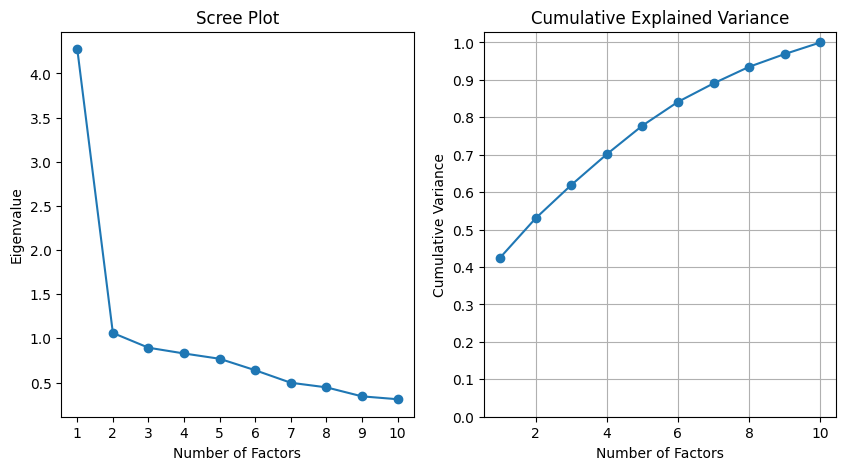

We will proceed with k = 2.

Unrotated Factor Loadings:
        Factor_1  Factor_2
AAPL_e   -0.6023    0.3537
ADBE_e   -0.4245    0.3215
ADP_e    -0.4561    0.1643
AMD_e    -0.5844    0.3618
DELL_e   -0.7516    0.0280
GTW_e    -0.5953    0.2115
HP_e     -0.3065    0.3624
IBM_e    -0.7055    0.1084
MSFT_e   -0.8397   -0.3550
ORCL_e   -0.4802    0.1322

Rotated (Varimax) Factor Loadings:
        Factor_1  Factor_2
AAPL_e   -0.3454    0.6071
ADBE_e   -0.2074    0.4905
ADP_e    -0.3133    0.3700
AMD_e    -0.3259    0.6052
DELL_e   -0.6373    0.3994
GTW_e    -0.4103    0.4803
HP_e     -0.0848    0.4670
IBM_e    -0.5572    0.4460
MSFT_e   -0.9049    0.1115
ORCL_e   -0.3501    0.3543


In [29]:
factor_analysis(market_stocks_df, excess_ret_names)

(f) Consider the model

$$r^{e}_t = \beta_1 \mathbb{1}_{t < t_0}r^{e}_M + \beta_2 \mathbb{1}_{t \geq t_0}r^{e}_M + \epsilon_t$$

in which $r^{e}_t=r_t-r_f$ and $r^{e}_M=r_M-r_f$ are the excess returns of the stock and the S&P 500 index. The model suggests that the $\beta$ in the CAPM might not be a constant (i.e., $\beta_1 \neq \beta_2$). Taking February 2001 as the month $t_0$, test for each stock the null hypothesis that $\beta_1 = \beta_2$.

In [31]:
# Data starts Jan 1994. 
# (2001 - 1994) * 12 + (Feb - Jan) = 7 * 12 + 1 = 85
# This is the 85th data point (index 84 because 0-indexed)
BREAKPOINT_T0_INDEX = 84

In [36]:
market_stocks_df.iloc[84]

sp500     0.014788
3mTCM     0.051500
AAPL      0.176157
ADBE     -0.116963
ADP      -0.023965
AMD       0.284978
DELL      0.191755
GTW       0.074788
HP        0.037967
IBM       0.127262
MSFT      0.159964
ORCL      0.000896
MER      -0.036712
AAPL_e    0.124657
ADBE_e   -0.168463
ADP_e    -0.075465
AMD_e     0.233478
DELL_e    0.140255
GTW_e     0.023288
HP_e     -0.013533
IBM_e     0.075762
MSFT_e    0.108464
ORCL_e   -0.050604
Name: 2001-01-01 00:00:00, dtype: float64

In [41]:
def capm_model_betas(df, stock_e_name, MER):
    """
    Test H0: beta1 = beta2 in the no-intercept model with a break at Feb 2001.
    Model: r_t^e = beta1 * 1(t<t0) * MER + beta2 * 1(t>=t0) * MER + epsilon
    """
    for stock_name in stock_e_name:
        print(f"\nTest H0: beta1 = beta2 for {stock_name}")
        
        Y = df[stock_name]
        n = len(Y)
        
        # 1. Create the two regressors for the unrestricted model
        X1 = np.zeros(n)
        X2 = np.zeros(n)
        
        X1[:BREAKPOINT_T0_INDEX] = MER.iloc[:BREAKPOINT_T0_INDEX]
        X2[BREAKPOINT_T0_INDEX:] = MER.iloc[BREAKPOINT_T0_INDEX:]
        
        X_unrestricted = pd.DataFrame({'X1_beta1': X1, 'X2_beta2': X2}, index=df.index)
        
        # Fit unrestricted model (no intercept): Y = b1*X1 + b2*X2
        model_unrestricted = sm.OLS(Y, X_unrestricted).fit()
        rss_u = model_unrestricted.ssr
        k_u = 2 # Number of parameters
        
        # 2. Create the regressor for the restricted model (H0: b1 = b2 = b)
        # Model: Y = b * (X1 + X2) = b * MER
        X_restricted = MER
        
        # Fit restricted model (no intercept)
        model_restricted = sm.OLS(Y, X_restricted).fit()
        rss_r = model_restricted.ssr
        k_r = 1 # Number of parameters
        
        # 3. Calculate F-statistic
        q = k_u - k_r # Number of restrictions
        
        F_stat = ((rss_r - rss_u) / q) / (rss_u / (n - k_u))
        p_value = 1.0 - f.cdf(F_stat, q, n - k_u)
        
        print(f"F-statistic: {F_stat:9.6f} (df_num={q}, df_den={n - k_u})")
        print(f"p-value    : {p_value:9.6f}")
        if p_value < 0.05:
            print("Result: Reject H0. The betas are likely different (p < 0.05).")
        else:
            print("Result: Fail to reject H0. No strong evidence of a break (p >= 0.05).")

In [42]:
capm_model_betas(market_stocks_df, excess_ret_names, market_stocks_df['MER'])


Test H0: beta1 = beta2 for AAPL_e
F-statistic:  2.122474 (df_num=1, df_den=154)
p-value    :  0.147188
Result: Fail to reject H0. No strong evidence of a break (p >= 0.05).

Test H0: beta1 = beta2 for ADBE_e
F-statistic:  2.096994 (df_num=1, df_den=154)
p-value    :  0.149622
Result: Fail to reject H0. No strong evidence of a break (p >= 0.05).

Test H0: beta1 = beta2 for ADP_e
F-statistic:  2.105004 (df_num=1, df_den=154)
p-value    :  0.148852
Result: Fail to reject H0. No strong evidence of a break (p >= 0.05).

Test H0: beta1 = beta2 for AMD_e
F-statistic:  1.492320 (df_num=1, df_den=154)
p-value    :  0.223724
Result: Fail to reject H0. No strong evidence of a break (p >= 0.05).

Test H0: beta1 = beta2 for DELL_e
F-statistic:  0.523597 (df_num=1, df_den=154)
p-value    :  0.470409
Result: Fail to reject H0. No strong evidence of a break (p >= 0.05).

Test H0: beta1 = beta2 for GTW_e
F-statistic:  6.959195 (df_num=1, df_den=154)
p-value    :  0.009195
Result: Reject H0. The betas 

(g). Estimate $t_0$ in (f) by the least squares criterion that minimizes the residual sum of squares over $(\beta_1, \beta_2, t_0)$

In [45]:
def least_squares_t0(df, stock_e_names, MER):
    """
    Estimates t0 by minimizing RSS for the model in (f).
    """
    
    for stock_e_name in stock_e_names:
        print(f"\nAnalysis for: {stock_e_name}")

        Y = df[stock_e_name]
        n = len(Y)
        
        # Set trim to 15% (common practice)
        trim = int(0.15 * n)
        possible_t0s = range(trim, n - trim)
        rss_values = []
        
        for t0_idx in possible_t0s:
            X1 = np.zeros(n)
            X2 = np.zeros(n)
            X1[:t0_idx] = MER.iloc[:t0_idx]
            X2[t0_idx:] = MER.iloc[t0_idx:]
            X_g = pd.DataFrame({'X1': X1, 'X2': X2}, index=df.index)
            
            model_g = sm.OLS(Y, X_g).fit()
            rss_values.append(model_g.ssr)
            
        # Find the index that minimizes RSS
        min_rss_internal_idx = np.argmin(rss_values)
        best_t0_index = possible_t0s[min_rss_internal_idx]
        best_t0_date = df.index[best_t0_index]
        
        print(f"Optimal breakpoint t0 found at index: {best_t0_index}")
        print(f"This corresponds to the date: {best_t0_date.strftime('%Y-%m')}")
        print(f"Minimum RSS at this break : {min(rss_values):.6f}")

In [46]:
least_squares_t0(market_stocks_df, excess_ret_names, market_stocks_df['MER'])


Analysis for: AAPL_e
Optimal breakpoint t0 found at index: 84
This corresponds to the date: 2001-01
Minimum RSS at this break : 0.586858

Analysis for: ADBE_e
Optimal breakpoint t0 found at index: 81
This corresponds to the date: 2000-10
Minimum RSS at this break : 0.589714

Analysis for: ADP_e
Optimal breakpoint t0 found at index: 96
This corresponds to the date: 2002-01
Minimum RSS at this break : 0.084005

Analysis for: AMD_e
Optimal breakpoint t0 found at index: 90
This corresponds to the date: 2001-07
Minimum RSS at this break : 0.893305

Analysis for: DELL_e
Optimal breakpoint t0 found at index: 61
This corresponds to the date: 1999-02
Minimum RSS at this break : 0.412091

Analysis for: GTW_e
Optimal breakpoint t0 found at index: 80
This corresponds to the date: 2000-09
Minimum RSS at this break : 0.677496

Analysis for: HP_e
Optimal breakpoint t0 found at index: 62
This corresponds to the date: 1999-03
Minimum RSS at this break : 0.320000

Analysis for: IBM_e
Optimal breakpoint